<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/master/Class_04_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 4: Training for Tabular Data**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Integrative Biology](https://sciences.utsa.edu/integrative-biology/), [UTSA](https://www.utsa.edu/)

### Module 4 Material

* Part 4.1: Encoding a Feature Vector for Keras Deep Learning
* Part 4.2: Keras Multiclass Classification for Deep Neural Networks with ROC and AUC
* **Part 4.3: Keras Regression for Deep Neural Networks with RMSE**
* Part 4.4: Backpropagation, Nesterov Momentum, and ADAM Neural Network Training

In [1]:
# You MUST run this code cell first

# Classification neural network
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
import pandas as pd

import os
import shutil
path = '/'
memory = shutil.disk_usage(path)
dirpath = os.getcwd()
print("Your current working directory is : " + dirpath)
print("Disk", memory)

Your current working directory is : C:\Users\David\BIO1173_Test\Class_04_3
Disk usage(total=4000108531712, used=1006323814400, free=2993784717312)


### Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [2]:
# YOU MUST RUN THIS CELL FIRST

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


## Datasets for Class_04_3

For Class_04_3 we will be using the Body Fat dataset for the Examples, and the Medical Costs dataset for the **Exercises**.

## **Body Fat Dataset**

[Body Fat Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/body-fat-prediction-dataset) 

Volume, and hence body **_density_**, can be accurately measured in a variety of ways. One of the most precise ways in called [underwater weighing](https://en.wikipedia.org/wiki/Hydrostatic_weighing) or more formally, **_hydrostatic weighing_**

This method computes body volume as the difference between body weight measured in air and weight measured during water submersion. In other words, body volume is equal to the loss of weight in water with the appropriate temperature correction for the water's density. 

**Image of a woman having her body density measured by Hydrostatic Weighing**

![___](https://biologicslab.co/BIO1173/images/underwater-weigh.jpg)


The mathematical formulas used in this technique are as follows:

$Body Density = \frac{W_{A}}{(W_{A} - W_{W}/c.f.- LV)}$        

where:

* $W_{A}$ = Weight in air (kg)
* $W_{W}$ = Weight in water (kg)
* $c.f.$ = Water correction factor =0.997 at 76-78 deg F)
* $LV$ = Residual Lung Volume (liters)

While very precise, determining a person's body density by water submersion is at best inconvienient. Wearing a swimsuit, you are completely immersed into a tank of water and are asked to expel as much air from your lungs as possible. A measurement is taken, and the displacement of water is measured to determine body density. Typically, 4 to 5 trials are repeated. Testing usually takes about 10-15 minutes.

In the Examples below we will see if we can construct and train a deep neural network that can make accurate predictions body density with hydrostatic submersion, using a Keras linear regression neural network and a set of clinical measurements.  
  
The factors (X-values) for training your neural network are:

* **Percent body fat:** from Siri's (1956) equation
* **Age:** (years)
* **Weight:** (lbs)
* **Height:** (inches)
* **Neck circumference:** (cm)
* **Chest circumference:** (cm)
* **Abdomen 2 circumference:** (cm)
* **Hip circumference:** (cm)
* **Thigh circumference:** (cm)
* **Knee circumference:** (cm)
* **Ankle circumference:** (cm)
* **Biceps (extended) circumference:** (cm)
* **Forearm circumference:** (cm)
* **Wrist circumference:** (cm)

The response variable (Y) that your neural network will try to predict is:
* **Density:** determined from underwater weighing

## **Medical Costs Dataset**

[Medical Costs Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance)  


![___](https://biologicslab.co/BIO1173/images/Health_Spending.jpg)

Understanding the factors involved in personal medical costs in the US is important for several reasons:

* **Financial burden:** Medical costs can be a significant financial burden for individuals and families, impacting their ability to afford necessary healthcare services. Understanding the factors influencing these costs can help individuals make informed decisions about their healthcare spending and budgeting.
* **Access to healthcare:** High medical costs can create barriers to accessing healthcare services, particularly for individuals with limited financial resources. By understanding the factors contributing to medical costs, policymakers and healthcare providers can work towards improving affordability and access to care.
* **Health outcomes:** The cost of healthcare can influence individuals' decisions to seek treatment or adhere to medical recommendations. Understanding factors influencing medical costs can help identify disparities in access to care and develop interventions to improve health outcomes.
* **Policy implications:** Knowledge of the factors shaping personal medical costs can inform healthcare policies and regulations aimed at controlling costs, improving quality of care, and expanding access to healthcare services. This understanding is crucial for policymakers seeking to address healthcare affordability and sustainability in the US.

The Medical Costs dataset contains statistical information about the insurance medical bill (`charges`) for individuals (_n_=1338) living in 4 different areas of the US. 

The dataset included some of the factors (X-variables) that contribute to medical costs including: 
* **age:** age of primary beneficiary
* **sex:** insurance contractor gender, female, male
* **bmi:** Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / $m^2$) using the ratio of height to weight, ideally 18.5 to 24.9
* **children:** Number of children covered by health insurance / Number of dependents
* **smoker:** Smoking
* **region:** the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

The response variable (Y) that your neural network will try to predict will be:
* **charges:** Individual medical costs billed by health insurance

# Part 4.3: Keras Regression for Deep Neural Networks with RMSE

In Keras, regression models can be built using deep neural networks to predict continuous values. The RMSE (Root Mean Squared Error) is a common metric used to evaluate the performance of regression models. It measures the average magnitude of the errors between predicted and actual values. To train a regression model using Keras, you would typically define a deep neural network architecture with dense layers, activation functions, and optimizer. The target variable would be continuous and the loss function used would be mean squared error (MSE).

During training, the model would minimize the MSE loss function by adjusting the weights and biases of the neural network using backpropagation. The model's performance can be evaluated using RMSE on a separate test dataset, where a lower RMSE indicates a better performing model. Overall, Keras Regression for Deep Neural Networks with RMSE involves building a neural network for regression tasks, training it using MSE loss, and evaluating its performance using RMSE.

We evaluate regression results differently than classification.  Consider the following code that trains a neural network for regression on the data set **jh-simple-dataset.csv**.  We begin by preparing the data set.

### Example 1: Read the datafile, create DataFrame and display

The code in the cell below reads the Body Fat datafile, `bodyfat.csv` from the course HTTPS server and creates a DataFrame called `bfDF`. The display options are set for 6 rows and 8 columns.

In [3]:
# Example 1: Read data, create DataFrame and display

# Read the data set
bfDF = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/bodyfat.csv",
    na_values=['NA','?'])

# Set display options
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 8)

# Display DataFrame
display(bfDF)

,Density,BodyFat,Age,Weight,...,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,...,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,...,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,...,24.0,28.8,25.2,16.6
...,...,...,...,...,...,...,...,...,...
249,1.0328,29.3,72,186.75,...,21.5,31.3,27.2,18.0
250,1.0399,26.0,72,190.75,...,22.7,30.5,29.4,19.8
251,1.0271,31.9,74,207.50,...,24.6,33.7,30.0,20.9


If you code is correct you should see the following table:

![___](https://biologicslab.co/BIO1173/images/class_04_3_Exe1.png)



### **Exercise 1: Read the datafile, create DataFrame and display**

In the cell below, read `Medical Costs` datafile `medical_costs.csv` from the course HTTPS server and creates a DataFrame called `mcDF`. Set your display options for 6 rows and 7 columns.

In [4]:
# Insert your code for Exercise 1 here



If you code is correct you should see the following table:

![___](https://biologicslab.co/BIO1173/images/class_04_3_Exm1.png)



### Example 2: Determine Preprocessing Steps

In almost every instance, some degree of preprocessing must be done before data can be used for training a neural network. The cell below uses the Pandas method `df.info()` to print out a list of the data types in the different columns in a DataFrame. 

Dependent on the number of columns in the DataFrame, you may have to adjust the number of rows to display. Since the DataFrame `bfDF` has 15 columns, the number of rows to display had to be set to 15, as shown below. 

In [5]:
# Example 2: Print data types

# Set num of row to number of columns in DF
pd.set_option('display.max_rows', 15)

# Print data types
print(bfDF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   BodyFat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB
None


If your code is correct you should see the following output:

If your code is correct, you should see the following output:

~~~text
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   BodyFat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB
None
~~~

You should pay attentions to two features. First, see if there are any differences in the `Non-Null Count`. In this case, all of the Non-Null Counts are the same (`252`). If there were different values, that would indicate missing data. 

The second feature you should pay attention to is the data type (`Dtype`). Columns with data types that are either `int64` or `float64` are numeric while columns that are `object` are categorical (string) values which must be converted into numerical values during data preprocessing. 

At least for our Body Fat DataFrame, `bfDF`, we don't have to worry about preprocessing any categorical values.


### **Exercise 2: Determine Preprocessing Steps**

In the cell below use the Pandas method `pd.info()` to print out a list of the data types in the DataFrame `mcDF`. Since this DataFrame has 7 columns, set the number of rows to display to be set to 7.

In [6]:
# Insert your code for Exercise 2 here



If your code is correct you should see the following output:
~~~text
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
~~~
Again, columns with data types that are either `int64` or `float64` are numeric while columns that are `object` are categorical (string) values. In the Medical Costs data set there are 3 columns with categorical values, `sex`, `smoker` and `region`. You will have to convert these strings into numerical values during data preprocessing.

### Example 3: Preprocess, Create Feature Vectors and Split Data

We know from Example 2 that `bfDF` only has numeric values so there are no string data to worry about. However, with numeric data it is generally a good idea to standardize the values. 

Standardizing numeric values helps ensure that features are on a similar scale, which can lead to faster convergence during training. Neural networks often perform better when input features are standardized as it makes it easier for the optimizer to find the optimal weights and biases.

The code in the cell below standardizes all of the columns in the Body Fat dataset with the notable exception of the target column, `Density` by converting the values into their Z-scores using this code chunk:
~~~text
# Generate column list for preprocessing
bfX_columns = bfDF.columns.drop('Density')

# Replace values with their Z-scores
for col in bfX_columns:
    bfDF[col] = zscore(bfDF[col])
~~~
Once the data has been standardize, we can reuse the variable `bfX_columns` to create our X feature vector usin this code chunk:
~~~text
# Generate X feature vector
bfX = bfDF[bfX_columns].values
bfX = np.asarray(bfX).astype('float32')
~~~~
Since we are building a **_regression_** neural network, we **_don't_** want ti One-Hot Encode the response (Y) variable `density`. Instead, we simply convert the values in the column `Density` in a Numpy array using the `.values` method:
~~~text
# Generate Y feature vector
bfY = bfDF['Density'].values
bfY = np.asarray(bfY).astype('float32')
~~~
The last preprocessing step is to split our feature vectors `bfX` and `bfY` into training and test (validation) data sets. The parameter, `test_size=0.25` specifies that we want about 25% of the X and Y data going into the test data sets `bfX_test` and `bfY_test`, respectively, and the rest of the data going into the training data sets `bfX_train` and `bfY_train`.  

As a final check, we print out the X data for the first 4 subjects in the test or validation set, `bfX_test`.  

In [7]:
# Example 3: Preprocess data, generate X and Y, split data

# Generate column list for preprocessing
bfX_columns = bfDF.columns.drop('Density')

# Replace values with their Z-scores
for col in bfX_columns:
    bfDF[col] = zscore(bfDF[col])

# Generate X feature vector
bfX = bfDF[bfX_columns].values
bfX = np.asarray(bfX).astype('float32')

# Generate Y feature vector
bfY = bfDF['Density'].values
bfY = np.asarray(bfY).astype('float32')

# Split data
bfX_train, bfX_test, bfY_train, bfY_test = train_test_split(    
    bfX, bfY, test_size=0.25, random_state=42)

# Print out first 4 of bfX_test
np.set_printoptions(suppress=True,precision=4)
print(bfX_test[0:4])

[[ 0.0059 -0.786   1.2981  0.9851  1.0337  0.7934  0.2364  0.6427  1.0295
   1.1257  1.4765  1.3686  2.4972  1.256 ]
 [ 0.0059 -1.5015  0.0708 -0.1091 -0.6562  0.5082 -0.1725  0.0553 -0.192
  -0.1207 -0.1196 -0.1238 -0.4284 -0.5686]
 [ 1.0595 -0.1499  0.1475 -0.0407 -0.3677  0.8529  1.1563  0.4329  0.8195
   0.5856  0.2942  0.4068 -0.4284 -0.8906]
 [ 0.1615 -0.786  -0.0571  0.2328  0.1681 -0.0385 -0.2096 -0.1685 -0.3065
  -0.5361 -0.4152 -0.4223  0.0179 -0.5686]]


If your code is correct you should see the following output:

~~~text
[[ 0.0059 -0.786   1.2981  0.9851  1.0337  0.7934  0.2364  0.6427  1.0295
   1.1257  1.4765  1.3686  2.4972  1.256 ]
 [ 0.0059 -1.5015  0.0708 -0.1091 -0.6562  0.5082 -0.1725  0.0553 -0.192
  -0.1207 -0.1196 -0.1238 -0.4284 -0.5686]
 [ 1.0595 -0.1499  0.1475 -0.0407 -0.3677  0.8529  1.1563  0.4329  0.8195
   0.5856  0.2942  0.4068 -0.4284 -0.8906]
 [ 0.1615 -0.786  -0.0571  0.2328  0.1681 -0.0385 -0.2096 -0.1685 -0.3065
  -0.5361 -0.4152 -0.4223  0.0179 -0.5686]]
~~~
This output is the X-values for 4 subjects in the test set (`bfX_test`). For each subject there are 14 floating-point numbers representing the Z-score values. The order of this values is the same order as the column names in `bfDF`.


### **Exercise 3: Preprocess data, generate X and Y, split data**

From the results of **Exercise 2**, we know that your DataFrame `mcDF` has three columns with categorical values: `sex`, `smoker` and `region`. Since the columns `sex` and `smoker` are **_binary_** (only contain two values), you should use `mapping` to convert the categorical values into integers. Here is the code chunk for mapping the column `sex`:
~~~text
# Map sex
mapping = {'male': 1, 'female': 0}
mcDF['sex'] = mcDF['sex'].map(mapping)
~~~
You can use this as a template to map the strings `yes` and `no` in the `smoker` column to `1` and `0`.

The column `region` contains 4 strings: `northeast`, `northwest`, `southeast` and `southwest`. In this instance, you should use `One-Hot Encoding`, instead of mapping, to preprocess the strings in `region` using the Pandas function `pd.get_dummies()` as shown as in this code chunk:
~~~text
# Generate dummies for region
mcDF = pd.concat([mcDF,pd.get_dummies(mcDF['region'],prefix="region")],axis=1)
mcDF.drop('region', axis=1, inplace=True
~~~
There are two columns with numeric values, `age` and `bmi`, the need to be standardized to their Z-scores. In this situation, it probably makes more sense simply to specify individual column by name as shown in this code chunk:
~~~text
# Standardize ranges to z-scores
mcDF['age'] = zscore(mcDF['age'])
mcDF['bmi'] = zscore(mcDF['bmi'])
~~~

Once the data has been standardize, generate the independent (X) values by first creating  a list of columns to be included, called `mcX_columns`, making sure to drop the target column, `charges`. 

Then generate the Y-values for the regression directly from the target column, `charges`. Again, it is very important **not** to One-Hot Encode the Y-values in a regression analysis! We just want to use the numerical values as they are.

Finally, split the X-values in `mcX` and the Y-values in `mcY` into training and test (validation) data sets setting the parameter,`test_size=0.25`. The test data sets should be called `mcX_test` and `mcY_test`, and the training data sets called `mcX_train` and `mcY_train`. 

As a final check, print out the X data for the first 4 subjects in the test or validation set, `mcX_test`.  

There are two columns with numeric values, `age` and `bmi`, the need to be standardized to the Z-scores.

Once the data has been standardize, generate the independent (X) values by first creating  a list of columns to be included, called `mcX_columns`, making sure to drop the target column, `charges`. 

Then generate the Y-values for the regression directly from the target column, `charges`. Again, it is very important **not** to One-Hot Encode the Y-values in a regression analysis! We just want to use the numerical values as they are.

Finally, split the X-values in `mcX` and the Y-values in `mcY` into training and test (validation) data sets setting the parameter,`test_size=0.25`. The test data sets should be called `mcX_test` and `mcY_test`, and the training data sets called `mcX_train` and `mcY_train`. 

As a final check, print out the X data for the first 4 subjects in the test or validation set, `mcX_test`.  

In [8]:
# Insert your code for Exercise 3 here



If your code is correct you should see something similar to the following output:

If your code is correct you should see something similar to the following output:
~~~text
[[ 0.4125  0.     -0.9003  2.      0.      1.      0.      0.      0.    ]
 [-0.2283  0.     -0.1055  0.      0.      0.      1.      0.      0.    ]
 [ 1.7653  0.     -0.6198  0.      1.      0.      1.      0.      0.    ]
 [ 0.4837  1.     -0.8068  3.      0.      0.      1.      0.      0.    ]]
~~~
These are the values for: `age` (z-score), sex, bmi (z-score), children, smoker and the last 4 values are the dummy columns for `region`. 

You can tell the gender of these subjects by the 2nd value in each array. In this particular example, the first three subjects have 0 as the second value, so they are female, while the 4th subject has 1, making him a male. 

### Example 4: Construct, Compile and Train Model

The code in the cell below constructs a linear ("sequential") regression neural network called `bfModel` with 3 hidden layers with: 

* **50 neurons** in Hidden #1
* **25 neurons** in Hidden #2
* **10 neurons** in Hidden #3

All neurons are `Dense` connected.

Since this is a regression neural network, there is only a single neuron in the output layer. The "voltage" in this neuron at the end of each run (epoch) represents the neural network's prediction of an individual's body `density`.  

Since the objective of the model `bfModel` is regression, we compile the model using the 'mean_squared_error' as the loss function along with `adam` as the optimizer.

An EarlyStopping monitor called `bfMonitor` is created to stop the training if the value for the `validation loss` doesn't increase after waiting 50 epochs. 

Finally, the model is trained ("fitted") for 1000 epochs using the training and test data created in Example 3. The verbose setting (output) is set to 0. 

In [9]:
# Example 4: Construct, compile and train model

# Construct model---------------------------------------------------
bfModel = Sequential()
bfModel.add(Dense(50, input_dim=bfX.shape[1], 
                  activation='relu')) # Hidden 1
bfModel.add(Dense(25, activation='relu')) # Hidden 2
bfModel.add(Dense(10, activation='relu')) # Hidden 3
bfModel.add(Dense(1)) # Output

# Compile model-------------------------------------------------------
bfModel.compile(loss='mean_squared_error', optimizer='adam')

# Create monitor------------------------------------------------------
bfMonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=50, verbose=1, mode='auto', 
                        restore_best_weights=True)

# Train model---------------------------------------------------------
bfModel.fit(bfX_train,bfY_train,validation_data=(bfX_test,bfY_test),
          callbacks=[bfMonitor],verbose=0,epochs=1000)


Restoring model weights from the end of the best epoch: 127.
Epoch 177: early stopping


Since the variable `verbose` is set to `0`, you will **NOT** see anything happening when you run the next cell. It will take some time to complete training before you can see any output. 

> ### **SO PLEASE BE PATIENT.** 

Assuming everything went smoothly, you should see something similar to the output below:
~~~text
Restoring model weights from the end of the best epoch: 184.
Epoch 234: early stopping

<keras.callbacks.History at 0x26bf045ba30>
~~~
In this particular example, the lowest validation loss occured after epoch 184. The model ran another 50 epochs before the monitor `bfMonitor` terminated the fitting and restored the connection weights between all of the neurons to the value they had at the end of the 184st epoch. 

### **Exercise 4: Construct, Compile and Train Model**

In the cell below constructs a linear ("sequential") regression neural network called `mcModel` with 3 hidden layers. Put 50 neurons in the 1st layer, 25 neurons in the second layer and 10 neurons in the 3rd layer. Make sure that there is only a single neuron in the output layer.   

Compile the model using the 'mean_squared_error' as the loss function along with `adam` as the optimizer.

Create an EarlyStopping monitor called `mcMonitor` to stop the fitting process if the value for the `validation loss` doesn't increase after waiting 50 epochs. 

Finally, fit your model for 1000 epochs using the training and test data created in **Exercise 3**. 

You may set the verbose argument to either `0` (no output) or `2` (output after each epoch). In either case, your model `mcModel` will take significantly **LONGER** to run than the previous model. If you select `verbose=2` be prepared for several "pages" of screen output.

In [10]:
# Insert your code for Exercise 4 here



If you set the argument `verbose` to `0`, don't expect to see any output for a few minutes. 

Here is the output with `verbose=0` after waiting a few minutes for training to terminate. 
~~~text
Restoring model weights from the end of the best epoch: 443.
Epoch 493: early stopping

<keras.callbacks.History at 0x26beb859d60>
~~~

## Mean Square Error

Using **_Mean Squared Error (MSE)_** for regression neural networks is common for several reasons:

* **Differentiable and continuous:** MSE is a differentiable and continuous loss function, making it suitable for optimization algorithms like gradient descent. This allows the neural network to update its parameters smoothly during training to minimize the error.
* **Mathematically well-defined:** MSE calculates the average of the squared differences between predicted and actual values, providing a clear measure of how well the model is performing in terms of minimizing prediction errors. It provides a single, interpretable metric for assessing the model's performance.
* **Emphasis on outliers:** Squaring the errors in MSE gives higher weights to larger errors, making the model more sensitive to outliers in the data. This can be useful in regression tasks where accurately predicting extreme values is important.
* **Convex optimization:** MSE is convex, meaning it has a single global minimum, making it easier for optimization algorithms to find the optimal model parameters. This can lead to faster convergence during training.
* **Widely used:** MSE is a commonly used loss function for regression tasks in neural networks, which means there are well-established techniques and frameworks for implementing and optimizing models with MSE as the loss function.

The mean square error (MSE) is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit. If an MSE value has decreased for a model, that is good. However, beyond this, there is not much more you can determine. We seek to achieve low MSE values. The following equation demonstrates how to calculate MSE.

$$ \mbox{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $$


### Example 5: Compute MSE

The code in the cell below uses the function `metrics.mean_squared_error()` from the Python library called `scikit-learn` (alias `sklearn`) to compute the MSE for the model `bfModel`. This function takes 2 arguments. 

The first argument is an array containing what the model **_predicted_** for body `Density` for every subject in the validation dataset `bfX_test`. In the code cell below, this array is called `bfPred`.

The second argument is an array contain the  **_actual_** body `Density` for each subject in the validation dataset. These actual values were previously stored in the array called  `bfY_test`. 

In [11]:
# Example 5: Compute MSE

# Use model to predict values
bfPred = bfModel.predict(bfX_test)

# Compare predicted and actual values  
score = metrics.mean_squared_error(bfPred,bfY_test)

# Print results
print("Final score (MSE): {}".format(score))

2/2 [==============================] - 0s 3ms/step
Final score (MSE): 0.012974034994840622


If your code is correct, you should see the following output:

~~~text
2/2 [==============================] - 0s 3ms/step
Final score (MSE): 0.015650872141122818
~~~

The final MSE is a relatively small number so that's a good sign. However, when it comes to MSE its hard to know if that means our `bfModel` is highly accurate, or fairly inaccurate. When it comes to MSE, all you really know is that `smaller is better`.

### **Exercise 5: Compute MSE**

In the cell below use the function `metrics.mean_squared_error()` to compute the MSE for your model `mcModel`. Call your prediction `mcPred`. Print out the results as illustrated in Example 5. 

In [12]:
# Insert your code for Exercise 5 here



If your code is correct, you should see something similar to the following output:
~~~text
11/11 [==============================] - 0s 2ms/step
Final score (MSE): 19570264.0
~~~
Compared to the MSE computed above in Example 5, your final MSE for `mcModel`, 19570264.0, might seem to be extremely big number. However, looks can be deceiving.  Your model was measuring the cost of medical treatment in the _tens of thousands_ of dollars, while the other model, `bfModel` was measuring body density, which has an average (mean) value of only 0.31558996. That's one of the problems with MSE, its magnitude depends upon the magnitude of the variable that you are trying to predict. 

## Root Mean Square Error

Using Root Mean Squared Error (RMSE) for regression neural networks has several advantages:

* **Scale interpretation:** RMSE is in the same units as the target variable, providing a more interpretable measure of error compared to MSE. This makes it easier to understand the magnitude of the errors in the predicted values.
* **Outlier sensitivity:** RMSE penalizes large errors more heavily than smaller errors due to the square root operation, making the model more sensitive to outliers. This can be beneficial for regression tasks where accurately predicting extreme values is important.
* **Averaging effect:** RMSE averages the errors across all samples in the dataset, providing a single metric that represents the overall model performance. This can simplify the evaluation process and make it easier to compare different models.

The root mean square (RMSE) is essentially the square root of the MSE. Because of this, the RMSE error is in the same units as the training data outcome. We desire Low RMSE values. The following equation calculates RMSE.

$$ \mbox{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $$

### Example 6: Compute RMSE

The code in the cell below again uses the function `metrics.mean_squared_error()` from the Python library called `scikit-learn` (alias `sklearn`) to compute the MSE for the model `bfModel`. To compute the _Root_ Mean Squared Error, you simple take the square root of the MSE, using the Numpy function `np.sqrt()` as shown in the next line of code:
~~~text
score = np.sqrt(metrics.mean_squared_error(mcPred,mcY_test))
~~~


In [13]:
# Example 6: Compute RMSE

# Compute RMSE
score = np.sqrt(metrics.mean_squared_error(bfPred,bfY_test))

# Print RSME
print("Final score (RMSE): {}".format(score))

# Print mean of Y
print(f"Average body `Density`:{bfY_test.mean()}")

# Print comparison
print(f"RMSE as percent of mean `Density`:  {score/bfY_test.mean()}")

Final score (RMSE): 0.11390361934900284
Average body `Density`:1.0570443868637085
RMSE as percent of mean `Density`:  0.10775670409202576


If your code is correct you should see something similar to the following output:
~~~text
Final score (RMSE): 0.1251034438610077
Average body `Density`:1.0570443868637085
RMSE as percent of mean `Density`:  0.11835212260484695
~~~
In this particular example, the error in our `bfModel's` predictions is equal to about 11%. In other words, our model either predicted a value that was, on average, about 10% too high, or too low.  

### **Exercise 6: Compute RMSE**

In the cell below compute and print out the RMSE for your model `mcModel`, the average (mean) value of `charges` of the subjects in the validation set and 

To compute the _Root_ Mean Squared Error, you simple take the square root of the MSE, using the Numpy function `np.sqrt()` as shown in the next line of code:

~~~text
score = np.sqrt(metrics.mean_squared_error(mcPred,mcY_test))
~~~


In [14]:
# Insert your code for Exercise 6 here



If your code is correct you should see something similar to the following output:
~~~text
Final score (RMSE): 4423.8291015625
Average insurance `charges`:13277.865234375
RMSE as percent of mean `charges`:  0.3331732153892517
~~~
In this example, RMSE for your `mcModel` was \\$4,424. On average, the people in the validation group spent \\$13,278 on insurance `charges` each year. Therefore, when expressed as a percentage of the mean, the RMSE of your model was about 33% of the average costs. 

## Lift Chart

We often visualize the results of regression with a **_lift chart_**. Lift charts are graphical tools used to evaluate the performance of predictive models, including neural network models. The lift chart shows how much better the model is at predicting outcomes compared to a random model. They also help in understanding the model's ability to rank or classify instances correctly.

To generate a lift chart, perform the following activities:

* Sort the data by expected output and plot these values.
* For every point on the x-axis, plot that same data point's predicted value in another color.
* The x-axis is just 0 to 100% of the dataset. The expected always starts low and ends high.
* The y-axis is ranged according to the values predicted.

You can interpret the lift chart as follows:

* The expected and predict lines should be close. Notice where one is above the other.


### Example 7: Plot Lift Chart

The code in the cell below creates a function called `chart_regression()`. The function takes two arguments: (1) the model's **_predictions_** of the response variable for each subject in the dataset and (2) the **_actual_** response variable for each subject in the dataset. In this example, the `bfModel's` predictions are stored in the variable `bfPred` while the corresponding actual values are stored in `bfY`. 

The function begins by sorting the predicted and actual values by size, from small to large. The sorted predicted values are assigned to the variable `pred`. The actual values in `Y` are 'flattened'. This means all of the values stored in 2-dimensional arrays are converted into a single, contiguous one-dimensional array. 

The function plots two lines. In this example, the blue line shows all of the 'Density` values in the Body Fat dataset, with the smallest value to the largest value plotted left-to-right. 

The orange line shows the model's predicted value for each actual value. Sometimes the model's predictions are greater than the actual values (the orange line is above the blue) and sometimes the predicted values are lower than the actual values (the orange line is below the blue). 

The difference between these two lines are the _'errors'_ that are used in the calculation of the **Root Mean Squared _ERRORS_ (RMSE)**. 

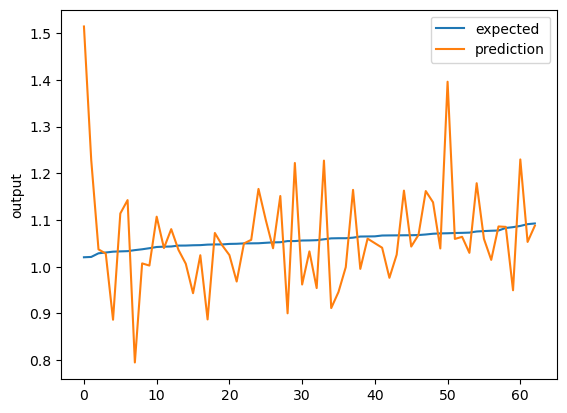

In [15]:
# Example 7: Plot Lift Chart

# Define plot function
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Use function to plot the chart
chart_regression(bfPred.flatten(),bfY_test)

If your code is correct you should see a Lift Plot similar to the one shown below.

![___](https://biologicslab.co/BIO1173/images/class_04_3_Lift1.png)

### **Exercise 7: Plot Lift Chart**

In the cell below plot the Lift Chart for your `mcModel` predictions.

In [16]:
# Insert your code for Exercise 7 here



If your code is correct you should see a Lift Plot similar to the one shown below.

![___](https://biologicslab.co/BIO1173/images/class_04_3_Lift2.png)

By visual inspect your `mcModel's` ability to predict the insurance costs (`charges`) becomes less accurate as the insurance costs start to increase more rapidly starting around an X value of 240. The reason for this sudden increase in variability is not immediately obvious. 

## **Lesson Turn-in**

When you have completed all of the code cells, and run them in sequential order (the last code cell should be number 16), use the **File --> Print.. --> Save to PDF** to generate a PDF of your JupyterLab notebook. Save your PDF as `Class_04_3.lastname.pdf` where _lastname_ is your last name, and upload the file to Canvas.